## Система оценки риска ДТП

**Задача проекта** — создать систему оценки риска ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

## Подключение к базе. Загрузка таблицы sql

In [6]:
# установка библиотеки для EDA
!pip install pandas-profiling
# установка модели catboost
!pip install catboost

     |████████████████████████████████| 268 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 13.3 MB/s eta 0:00:01
     |████████████████████████████████| 709 kB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 20.3 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 15.5 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=46c06edc5b042a100a9e7f8c0ba1abd3d6506d63b6325722c8fa41b05ef37883
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin


In [25]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns
import pandas_profiling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import catboost
import time
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
import catboost as ctb
import seaborn as sns

Мы будем работать с базой данных, поэтому нам небходимо создать подключение к ней. Запишем данные для подключения в отдельную переменную, сформируем строку для подключения со всеми параметрами подключения и создадим соединение.

In [2]:
# данные для подключения к базе данных
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [3]:
# формирование строки для подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [4]:
# создание соединения
engine = create_engine(connection_string) 

**Вывод:**

Подключились к базе данных. Теперь можно исследовать даные.

## Первичное исследование таблиц

Напишем для каждой таблицы запрос и выведем первые строки. Посмотрим на описание таблиц.

In [43]:
# запрос для таблицы case_ids
query_case_ids = '''
SELECT *
FROM case_ids;
''' 
# чтение таблицы
case_ids_df = pd.read_sql_query(query_case_ids, con = engine)

In [44]:
# вывод первых строк таблицы
case_ids_df.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [45]:
# запрос для таблицы vehicles
query_vehicles = '''
SELECT *
FROM vehicles;
''' 
# чтение таблицы
vehicles_df = pd.read_sql_query(query_vehicles, con = engine)

In [46]:
# вывод первых строк таблицы
vehicles_df.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


In [11]:
# запрос для таблицы collisions
query_collisions = '''
SELECT *
FROM collisions;
''' 
# чтение таблицы
collisions_df = pd.read_sql_query(query_collisions, con = engine)

In [12]:
# вывод первых строк таблицы
collisions_df.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [13]:
# запрос для таблицы parties
query_parties = '''
SELECT *
FROM parties;
''' 
# чтение таблицы
parties_df = pd.read_sql_query(query_parties, con = engine)

In [14]:
# вывод первых строк таблицы
parties_df.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


**Исходные данные:**



Таблица `collisions`— общая информация о ДТП

* **case_id** — уникальный номер для зарегистрированного происшествия в таблице происшествий
* **collision_date** — дата происшествия (год/месяц/день)
* **collision_time** — время происшествия (24-часовой формат)
* **intersection** — является ли место происшествие перекрёстком:
    * Y — Intersection (перекрёсток)
    * N — Not Intersection (не перекрёсток)
    * -- — Not stated (Не указано)
* **weather_1** — погода:
    * A — Clear (Ясно)
    * B — Cloudy (Облачно)
    * C — Raining (Дождь)
    * D — Snowing (Снегопад)
    * E — Fog (Туман)
    * F — Other (Другое)
    * G — Wind (Ветер)
    * -- — Not Stated (Не указано)
* **collision_damage** — серьёзность происшествия:
    * 1 — FATAL ТС (Не подлежит восстановлению)
    * 2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)
    * 3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)
    * 4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)
    * 0 – SCRATCH (Царапина)
* **primary_coll_factor** — основной фактор аварии:
    * A — Code Violation (Нарушение правил ПДД)
    * B — Other Improper Driving (Другое неправильное вождение)
    * C — Other Than Driver (Кроме водителя)
    * D — Unknown (Неизвестно)
    * E — Fell Asleep (Заснул)
    * -- — Not Stated (Не указано)
* **road_surface** — состояние дороги:
    * A — Dry (Сухая)
    * B — Wet (Мокрая)
    * C — Snowy or Icy (Заснеженная или обледенелая)
    * D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)
    * -- — Not Stated (Не указано)
* **lightning** — освещение:
    * A — Daylight (Дневной свет)
    * B — Dusk-Dawn (Сумерки-Рассвет)
    * C — Dark-Street Lights (Темно-Уличные фонари)
    * D — Dark-No Street Lights (Темно-Нет уличных фонарей)
    * E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)
    * -- — Not Stated (Не указано)
* **country_city_location** — номер географических районов, где произошло ДТП
* **country_location** — названия географических районов, где произошло ДТП
* **direction** — направление движения:
    * N — North (Север)
    * E — East (Восток)
    * S — South (Юг)
    * W — West (Запад)
    * -- or blank — Not State (Не указано)
* **distance** — расстояние от главной дороги (метры)
* **location_type** — тип дороги:
    * H — Highway (Шоссе)
    * I — Intersection (Перекрёсток)
    * R — Ramp (or Collector) (Рампа)
    * -- or blank — Not State Highway (Не указано)
* **party_count** — количество участников
* **pcf_violation_category** — категория нарушения:
    * 01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)
    * 02 — Impeding Traffic (Препятствие движению транспорта)
    * 03 — Unsafe Speed (Превышение скорости)
    * 04 — Following Too Closely (Опасное сближение)
    * 05 — Wrong Side of Road (Неправильная сторона дороги)
    * 06 — Improper Passing (Неправильное движение)
    * 07 — Unsafe Lane Change (Небезопасная смена полосы движения)
    * 08 — Improper Turning (Неправильный поворот)
    * 09 — Automobile Right of Way (Автомобильное право проезда)
    * 10 — Pedestrian Right of Way (Пешеходное право проезда)
    * 11 — Pedestrian Violation (Нарушение пешеходами)
    * 12 — Traffic Signals and Signs (Дорожные сигналы и знаки)
    * 13 — Hazardous Parking (Неправильная парковка)
    * 14 — Lights (Освещение)
    * 15 — Brakes (Тормоза)
    * 16 — Other Equipment (Другое оборудование)
    * 17 — Other Hazardous Violation (Другие нарушения)
    * 18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)
    * 19 — Speeding (Скорость)
    * 20 — Pedestrian dui (Нарушение пешехода)
    * 21 — Unsafe Starting or Backing (Опасный старт)
    * 22 — Other Improper Driving (Другое неправильное вождение)
    * 23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)
    * 24 — Fell Asleep (Заснул)
    * 00 — Unknown (Неизвестно)
    * -- — Not Stated (Не указано)
* **type_of_collision** — тип аварии:
    * A — Head-On (Лоб в лоб)
    * B — Sideswipe (Сторона)
    * C — Rear End (Столкновение задней частью)
    * D — Broadside (Боковой удар)
    * E — Hit Object (Удар объекта)
    * F — Overturned (Опрокинутый)
    * G — Vehicle (транспортное средство/ Пешеход)
    * H — Other (Другое)
    * -- — Not Stated (Не указано)
* **motor_vehicle_involved_with** — дополнительные участники ДТП:
    * MOTOR_VEHICLE_INVOLVED_WITH	Other motor vehicle (Другой автомобиль)
    * Fixed object (Неподвижный объект)
    * Parked motor vehicle (Припаркованный автомобиль)
    * Pedestrian (Пешеход)
    * Bicycle (Велосипедист)
    * Non-collision (Не столкновение)
    * Other object (Другой объект)
    * Motor vehicle on other roadway (Автомобиль на другой проезжей)
    * Animal (Животное)
    * Train (Поезд)
* **road_condition_1** — дорожное состояние:
    * A — Holes, Deep Ruts (Ямы, глубокая колея)
    * B — Loose Material on Roadway (Сыпучий материал на проезжей части)
    * C — Obstruction on Roadway (Препятствие на проезжей части)
    * D — Construction or Repair Zone (Зона строительства или ремонта)
    * E — Reduced Roadway Width (Уменьшенная ширина проезжей части)
    * F — Flooded (Затоплено)
    * G — Other (Другое)
    * H — No Unusual Condition (Нет ничего необычного)
    * -- — Not Stated (Не указано)
* **control_condition_1** — устройство управления:
    * A — Functioning (Функционирует)
    * B — Not Functioning (Не функционирует)
    * C — Obscured (Затемнённый)
    * D — None (Нет)
    * -- — Not Stated (Не указано)

Таблица `parties`— информация об участниках ДТП
 
* **case_id** — уникальный номер для зарегистрированного происшествия в таблице происшествий
* **party_number** — число участников происшествия
* **party_type** — тип участника происшествия:
    * 1 — Car (Авто)
    * 2 — Road bumper (Дорожные знаки)
    * 3 — Building (Строения)
    * 4 — Road signs (Отбойник)
    * 5 — Other (Другое)
    * 6 — Operator (Оператор)
    * -- — Not Stated (Не указано)
* **at_fault** — виновность участника (0/1)
* **insurance_premium** — cумма страховки (тыс. $)
* **party_drug_physical** — cостояние участника (физическое или с учётом принятых лекарств):
    * E — Under Drug Influence (Под воздействием лекарств)
    * F — Impairment — Physical (Ухудшение состояния)
    * G — Impairment Unknown (Не известно)
    * H — Not Applicable (Не оценивался)
    * I — Sleepy/Fatigued (Сонный/Усталый)
    * -- — Not Stated (Не указано)
* **party_sobriety** — трезвость участника:
    * A — Had Not Been Drinking (Не пил)
    * B — Had Been Drinking, Under Influence (Был пьян, под влиянием)
    * C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)
    * D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)
    * G — Impairment Unknown (Неизвестно ухудшение)
    * H — Not Applicable (Не оценивался)
    * -- — Not Stated (Не указано)
* **cellphone_in_use** — наличие телефона в автомобиле (возможности разговаривать по громкой связи)

Таблица `vehicles` — информация о пострадавших машинах

* **id** — номер в таблице
* **case_id** — уникальный номер для зарегистрированного происшествия в таблице происшествий
* **vehicle_type** — тип кузова:
    * MINIVAN
    * COUPE
    * SEDAN
    * HATCHBACK
    * OTHER
* **vehicle_transmission** — тип КПП:
    * auto (Автоматическая)
    * manual (Ручная)
    * -- — Not Stated (Не указано)
* **vehicle_age** — возраст автомобиля (в годах)

Загруженные таблицы непустые. Количество таблиц соответствует условию задачи. Для связи таблиц имеется общий ключ **case_id**.

**Вывод:**

Проведено первичное исследование таблиц на наличие данных и соответствие условию.

##  Cтатистический анализ факторов ДТП

Выясним, в какие месяца происходит наибольшее количество аварий. Проанализируем весь период наблюдений.

In [8]:
# запрос для анализа количества аварий
query_accident = '''
SELECT EXTRACT('MONTH' FROM collision_date)::int as month_date,
        COUNT(case_id) as accident_count
FROM collisions
GROUP BY month_date;
''' 
# создание таблицы для анализа
accident_df = pd.read_sql_query(query_accident, con = engine)

In [9]:
# просмотр первых строк
accident_df.head()

,month_date,accident_count
0,1,132044
1,2,128858
2,3,139581
3,4,130180
4,5,130316


Теперь построим график.

Text(0, 0.5, 'accident_count')

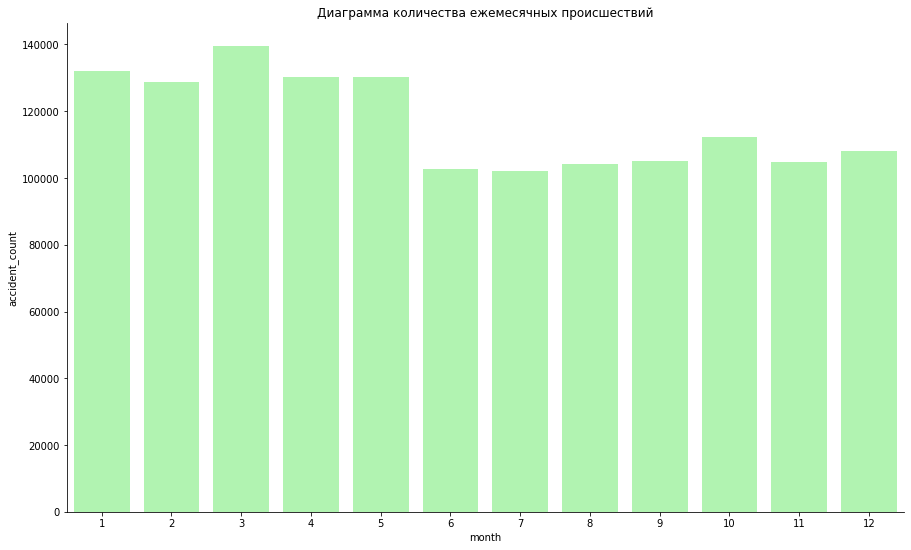

In [9]:
# диаграмма количества ежемесячных происшествий
f, ax = plt.subplots(figsize=(15, 9))
sns.despine(f)
g = sns.barplot(data=accident_df, x='month_date', y='accident_count',
                 palette='magma',
                 linewidth='.5',
                 facecolor='lightgreen',
                 color='green', alpha=0.7)

g.set_title('Диаграмма количества ежемесячных происшествий')
g.set_xlabel('month')
g.set_ylabel('accident_count')

Самое большое количество происшествий приходится на 3ий месяц - март, возможно это связано с таянием льда/снега, когда условия для вождения ухудшаются. В целом с января по май ежемесячное количество происшествий держится примерно на одном высоком уровне. Летом количество происшествий сокращается, это может быть связано с тем, что жители городов улетают в отпуск.

Ещё посмотрим на наполненность даннных по годам: за все ли месяца есть данные.

In [22]:
# запрос для анализа наполненности данных по годам
year_month_accident = '''
SELECT EXTRACT('YEAR' FROM collision_date)::int as year_date,
       COUNT(DISTINCT(EXTRACT('MONTH' FROM collision_date)::int)) as month_count
FROM collisions
GROUP BY year_date;
''' 
# создание таблицы для анализа
year_month_df = pd.read_sql_query(year_month_accident, con = engine)

In [23]:
# вывод таблицы
year_month_df

,year_date,month_count
0,2009,12
1,2010,12
2,2011,12
3,2012,12
4,2013,6
5,2020,2


Теперь построим график.

Text(0, 0.5, 'month_count')

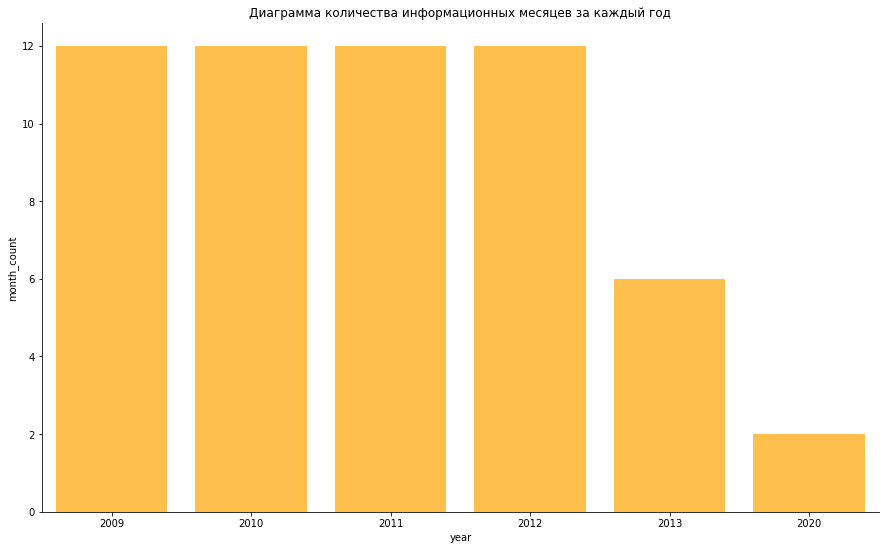

In [29]:
# диаграмма количества информационных месяцев за каждый год
f, ax = plt.subplots(figsize=(15, 9))
sns.despine(f)
g = sns.barplot(data=year_month_df, x='year_date', y='month_count',
                 palette='magma',
                 linewidth='.5',
                 facecolor='orange',
                 alpha=0.7)

g.set_title('Диаграмма количества информационных месяцев за каждый год')
g.set_xlabel('year')
g.set_ylabel('month_count')

Для исследования задачи не обходимо проработать следующие **аналитические задачи**:

* проанализировать зависимость возраста автомобиля от серьезности ДТП (таблицы *vehicles*, *collisions*)
* проанализировать зависимость времени происшествия и трезвости участника ДТП (таблицы *collisions*, *parties*)
* проанализировать зависимость основного фактора аварии от состояния участника (таблицы *collisions*, *parties*)
* проанализировать зависимость состояния дороги от типа участника происшествия (таблицы *collisions*, *parties*)
* проанализировать зависимость категории нарушения от наличия телефона в машине (таблицы *collisions*, *parties*)
* проанализировать зависимость физического состояния от возраста автомобиля (таблицы *vehicles*, *parties*)

Рекомендации для исследования первых двух аналитических задач из списка приведённого выше:

* Чтобы проанализировать зависимость возраста автомобиля от серьезности ДТП, необходимо создать *sql-запрос* с объединением таблиц *vehicles* и *collisions*, выгрузив колонки `vehicle_age`, `collision_damage`. Для ДТП разной серьёзности построить диаграммы распределения возрастов (можно распределить автомобили по возрастным группам) и выявить, начиная с какого возраста автомобиль в происшествиях сильно повреждается.

* Чтобы проанализировать проанализировать зависимость времени происшествия и трезвости участника ДТП, необходимо создать *sql-запрос* с объединением таблиц *vehicles* и *parties*, выгрузив колонки `collision_time`, `party_sobriety`. Выделить временные группы и для каждой группы вывести средний показатель трезвости, на этих данных построить диаграмму. Посмотреть, в какое время вероятность встретить на дороге нетрезвого водителя выше всего.

**Вывод:**

Проанализировано ежемесячное количество проишествий. Составлен план по исследованию данных.

## Подготовка данных для модели оценки водительского риска

По заданию заказчика необходимо учитывать следующие ограничения при использовании данных:
* тип виновника проишествия — только машина (car)
* использовать случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина)
* использовать данные за 2012 год

Сразу отберём те признаки, которые мы будем использовать при моделировании, чтобы выгружать только необходимые столбцы.

При моделировании нам понадобятся:
* `collision_date` — в зависимости от времени года степень опасности трассы может варьироваться
* `collision_time` — в ночное время вероятность происшествия возрастает
* `intersection` — на перекрёстке вероятность проишествия также возрастает, т.к. это сложное место для водителей
* `weather_1` — погода влияет на состояние трассы
* `collision_damage` — степень повреждения может косвенно говорить об обстановке на трассе
* `road_surface` — от состояния дороги зависит сложность/опасность трассы
* `lightning` — при плохом освеещнии вероятнось аварии повышается
* `country_city_location` — от геоположения (горы/равнина и т.д.) зависит сложность трассы
* `location_type` — от масштаба трассы зависит количество машин на ней, следовательно, и возможность аварии
* `pcf_violation_category` — категория нарушения говорит о степени опасности на дороге
* `type_of_collision` — тип аварии также говорит о степени опасности на дороге
* `motor_vehicle_involved_with` — дополнительно вовлеченные участники также говорят о степени опасности на дороге
* `road_condition_1` — состояние дороги непосредственно влияет на опасность трассы
* `party_drug_physical` — состояние водителя прямо влиет на его вождение, следовательно, и на успешное прохождение трассы
* `party_sobriety` — трезвость участника непосредственно коррелирует с успешным прохождением участка трассы
* `cellphone_in_use` — если у человека в автомобиле есть возможность говорить по громкой связи, то у него всегда будут свободны руки и он сможет полностью контролировать ситуацию на дороге
* `vehicle_age` — требование заказчика учесть возраст автомобиля
* `vehicle_transmission` — тип КПП может повляить на комфорт при вождении, возможно с механической коробкой передач сложнее вести управление автомобилем
* `at_fault` — целевой признак: вина в происшествии

In [5]:
# отбор необходимых признаков
query_for_model = '''
SELECT c.case_id, c.collision_date, c.collision_time,
       c.intersection, c.weather_1, c.collision_damage,
       c.road_surface, c.lighting, c.county_city_location,
       c.location_type, c.pcf_violation_category, c.type_of_collision,
       c.motor_vehicle_involved_with, c.road_condition_1,
       p.party_drug_physical, p.party_sobriety, p.cellphone_in_use,
       v.vehicle_age, v.vehicle_transmission, p.at_fault
FROM collisions AS c
INNER JOIN parties AS p ON c.case_id=p.case_id
INNER JOIN vehicles AS v ON v.case_id=c.case_id
WHERE EXTRACT('YEAR' FROM c.collision_date)::int = 2012
AND p.party_type = 'car'
AND c.collision_damage != 'scratch';
''' 

In [6]:
# создание датафрейма с необходимыми признаками
features_df = pd.read_sql_query(query_for_model, con = engine)

In [7]:
# вывод первых строк
features_df.head()

,case_id,collision_date,collision_time,intersection,weather_1,collision_damage,road_surface,lighting,county_city_location,location_type,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_condition_1,party_drug_physical,party_sobriety,cellphone_in_use,vehicle_age,vehicle_transmission,at_fault
0,5403037,2012-01-13,02:55:00,1.0,clear,fatal,dry,dark with street lights,3500,None,dui,hit object,fixed object,loose material,under drug influence,"had been drinking, under influence",0.0,3.0,manual,1
1,5403431,2012-01-11,18:03:00,0.0,clear,fatal,dry,dark with street lights,0112,ramp,dui,hit object,fixed object,normal,None,"had been drinking, under influence",NaN,6.0,manual,1
2,5403481,2012-02-16,18:25:00,0.0,clear,fatal,dry,dark with no street lights,2900,None,wrong side of road,head-on,other motor vehicle,normal,None,had not been drinking,0.0,6.0,manual,0
3,5403481,2012-02-16,18:25:00,0.0,clear,fatal,dry,dark with no street lights,2900,None,wrong side of road,head-on,other motor vehicle,normal,None,had not been drinking,0.0,10.0,manual,0
4,5403569,2012-02-17,04:38:00,0.0,clear,fatal,dry,dark with street lights,1942,highway,pedestrian violation,other,other object,normal,None,had not been drinking,0.0,2.0,auto,0


In [8]:
# просмотр типов даных
features_df.dtypes

case_id                         object
collision_date                  object
collision_time                  object
intersection                   float64
weather_1                       object
collision_damage                object
road_surface                    object
lighting                        object
county_city_location            object
location_type                   object
pcf_violation_category          object
type_of_collision               object
motor_vehicle_involved_with     object
road_condition_1                object
party_drug_physical             object
party_sobriety                  object
cellphone_in_use               float64
vehicle_age                    float64
vehicle_transmission            object
at_fault                         int64
dtype: object

Приведём колонку `collision_date` к типу данных *datetime*.

In [9]:
# приведение данных
columns = ['collision_date', 'collision_time']
for column in columns:
    features_df[column] = pd.to_datetime(features_df[column], errors = 'coerce')

In [10]:
# проверка типов данных
features_df.dtypes

case_id                                object
collision_date                 datetime64[ns]
collision_time                 datetime64[ns]
intersection                          float64
weather_1                              object
collision_damage                       object
road_surface                           object
lighting                               object
county_city_location                   object
location_type                          object
pcf_violation_category                 object
type_of_collision                      object
motor_vehicle_involved_with            object
road_condition_1                       object
party_drug_physical                    object
party_sobriety                         object
cellphone_in_use                      float64
vehicle_age                           float64
vehicle_transmission                   object
at_fault                                int64
dtype: object

Теперь посмотрим на наши данные с помощью библиотеки *pandas_profiling*. Разобьём данные на две части, т.к. ядро тетради может не выдержать столько данных.

In [14]:
# формирование аналитической сводки данных
pandas_profiling.ProfileReport(features_df[['collision_date', 'collision_time', 'intersection',
       'weather_1', 'collision_damage', 'road_surface', 'lighting',
       'county_city_location', 'at_fault']])

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# формирование аналитической сводки данных
pandas_profiling.ProfileReport(features_df[['location_type', 'pcf_violation_category',
       'type_of_collision', 'motor_vehicle_involved_with', 'road_condition_1',
       'party_drug_physical', 'party_sobriety', 'cellphone_in_use',
       'vehicle_age', 'vehicle_transmission']])

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Датасет содержит 2 типа признаков:
- категориальные 
- количественные

Значения признаков представлены следующими типами данных:
- `object`
- `int64`
- `float64`
- `datetime64[ns]`

Датасет содержит и дубликаты, и пропуски. Некоторые колонки имеют значительную долю пропусков (больше половины), такие колонки при обучении модели использовать не будем. К ним относятся: `location_type`, `party_drug_physical`. Остальные колонки либо не содержат пропусков, либо количество пропусков колеблется в районе 1-2%, от таких значений мы избавимся. Колонка `cellphone_in_use` содержит около 9% пропусков, это уже приличное значение. Не будем использовать эту колонку при моделировании, чтобы дополнительно не исключать данные, фактор возможности говорить по громкой связи влияет на вождение водителя, однако он не играет главную роль. Также при  моделировании не будем использовать колонку `collision_time`, т.к. колонки `lightning`, `weather_!` говорят о времени суток.

In [11]:
# удаление ненужных колонок
features_df.drop(columns=['location_type', 'party_drug_physical', 'collision_time'], inplace=True)

In [12]:
# удаление дубликатов
features_df.drop_duplicates(keep='first', inplace=True)
features_df.drop_duplicates(subset=['case_id'], keep='first', inplace=True)

In [13]:
# удаление пропусков
features_df.dropna(inplace=True)

In [14]:
# проверка наличия пропусков
features_df.isna().mean().reset_index()

,index,0
0,case_id,0.0
1,collision_date,0.0
2,intersection,0.0
3,weather_1,0.0
4,collision_damage,0.0
5,road_surface,0.0
6,lighting,0.0
7,county_city_location,0.0
8,pcf_violation_category,0.0
9,type_of_collision,0.0


Данные изучены и подготовлены к дальнейшему использованию. Теперь разделим датасет на *признаки* и *целевой признак*. Далее закодируем категориальные признаки и масштабируем численные.

In [15]:
# деление на признаки и целевой признак
features = features_df.drop(columns=['at_fault', 'case_id'])
target = features_df['at_fault']

# деление на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42
)

In [16]:
# подготовка инструментов для кодирования признаков
scaled_cols = ['vehicle_age']
ohe_cols = ['collision_date','intersection','weather_1','collision_damage',
            'road_surface','lighting','county_city_location','pcf_violation_category',
            'type_of_collision','motor_vehicle_involved_with','road_condition_1',
            'party_sobriety','cellphone_in_use','vehicle_age','vehicle_transmission']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(features_train[ohe_cols])
scaler = StandardScaler()
scaler.fit(features_train[scaled_cols])

StandardScaler()

In [17]:
# кодирование признаков тренировочной выборки
df_ohe_train = pd.DataFrame(
    encoder.transform(features_train[ohe_cols]),
    columns=encoder.get_feature_names(ohe_cols)
)

df_scale_train = pd.DataFrame(
    scaler.transform(features_train[scaled_cols]),
    columns = features_train[scaled_cols].columns
)

df_features_train = pd.concat([df_scale_train, df_ohe_train], axis=1)

In [18]:
# вывод первых пяти строк
df_features_train.head()

,vehicle_age,collision_date_2012-01-01T00:00:00.000000000,collision_date_2012-01-02T00:00:00.000000000,collision_date_2012-01-03T00:00:00.000000000,collision_date_2012-01-04T00:00:00.000000000,collision_date_2012-01-05T00:00:00.000000000,collision_date_2012-01-06T00:00:00.000000000,collision_date_2012-01-07T00:00:00.000000000,collision_date_2012-01-08T00:00:00.000000000,collision_date_2012-01-09T00:00:00.000000000,...,vehicle_age_10.0,vehicle_age_11.0,vehicle_age_12.0,vehicle_age_13.0,vehicle_age_14.0,vehicle_age_15.0,vehicle_age_16.0,vehicle_age_19.0,vehicle_transmission_auto,vehicle_transmission_manual
0,0.367294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.596591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.973770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.009884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.652475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
# кодирование признаков тестовой выборки
df_ohe_test = pd.DataFrame(
    encoder.transform(features_test[ohe_cols]),
    columns=encoder.get_feature_names(ohe_cols)
)

df_scale_test = pd.DataFrame(
    scaler.transform(features_test[scaled_cols]),
    columns = features_test[scaled_cols].columns
)

df_features_test = pd.concat([df_scale_test, df_ohe_test], axis=1)

In [20]:
# вывод первых пяти строк
df_features_test.head()

,vehicle_age,collision_date_2012-01-01T00:00:00.000000000,collision_date_2012-01-02T00:00:00.000000000,collision_date_2012-01-03T00:00:00.000000000,collision_date_2012-01-04T00:00:00.000000000,collision_date_2012-01-05T00:00:00.000000000,collision_date_2012-01-06T00:00:00.000000000,collision_date_2012-01-07T00:00:00.000000000,collision_date_2012-01-08T00:00:00.000000000,collision_date_2012-01-09T00:00:00.000000000,...,vehicle_age_10.0,vehicle_age_11.0,vehicle_age_12.0,vehicle_age_13.0,vehicle_age_14.0,vehicle_age_15.0,vehicle_age_16.0,vehicle_age_19.0,vehicle_transmission_auto,vehicle_transmission_manual
0,0.045999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.688589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.596591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.275296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.367294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Вывод:**

Данные подготовлены к обучению.

## Создание модели оценки водительского риска

Будем использовать три модели для сравнения результатов:
* **RandomForestClassifier()**
* **SGDClassifier()**
* **CatBoostClassifier()**

Сначала отберём лучшие параметры моделей с помощью *GridSearchCV()*, затем обучим модели и проверим на тестовой выборке.
Метрикой качества в нашей задаче будет **f1_score**, т.к. она покажет точность предсказания в среднем, основываясь на *precision* и *recall*. Для модели *CatBoostClassifier()* не будем отбирать лучшие параметры, т.к. при разработке этой модели был учтён поиск оптимальных параметров.

In [57]:
# подбор параметров модели RandomForestClassifier()
start_time = time.time()
rfr_pipe = Pipeline([('rfr', RandomForestClassifier(random_state=42))])
params_rfr = [{'rfr__max_depth': [5, 10, 15, 20],
               'rfr__n_estimators': [10, 20, 30, 40],
               'rfr__max_features':['auto', 'sqrt', 'log2']}]
gs_rfr = GridSearchCV(rfr_pipe,
                      param_grid=params_rfr,
                      scoring='f1',
                      cv=5)
gs_rfr.fit(df_features_train, target_train)
rfr_best_params = gs_rfr.best_params_

rfr_dict = {'model' : 'RandomClassifier()',
            'best_params' : rfr_best_params,
            'time_gs, sec' : round(time.time() - start_time, 3)}
rfr_dict

{'model': 'RandomClassifier()',
 'best_params': {'rfr__max_depth': 20,
  'rfr__max_features': 'auto',
  'rfr__n_estimators': 40},
 'time_gs, sec': 220.431}

In [58]:
# предсказание модели RandomForestClassifier()
start_time = time.time()
rfr = RandomForestClassifier(max_depth=20, max_features='auto', n_estimators=40, random_state=42)
rfr.fit(df_features_train, target_train)
rfr_preds = rfr.predict(df_features_test)

rfr_new_values = {'time_predict, sec' : round(time.time() - start_time, 3),
                  'f1_score' : round(f1_score(target_test, rfr_preds), 2)}
rfr_dict.update(rfr_new_values)
rfr_dict

{'model': 'RandomClassifier()',
 'best_params': {'rfr__max_depth': 20,
  'rfr__max_features': 'auto',
  'rfr__n_estimators': 40},
 'time_gs, sec': 220.431,
 'time_predict, sec': 3.226,
 'f1_score': 0.93}

In [59]:
# подбор параметров модели SGDClassifier()
start_time = time.time()
sgd_pipe = Pipeline([('sgd', SGDClassifier(random_state=42))])
params_sgd = [{'sgd__loss': ['hinge', 'log', 'modified_huber',
                             'squared_hinge', 'perceptron'],
               'sgd__alpha': [0.1, 0.001, 0.0001]}]
gs_sgd = GridSearchCV(sgd_pipe,
                      param_grid=params_sgd,
                      scoring='f1',
                      cv=5)
gs_sgd.fit(df_features_train, target_train)
sgd_best_params = gs_sgd.best_params_

sgd_dict = {'model' : 'SGDClassifier()',
            'best_params' : sgd_best_params,
            'time_gs, sec' : round(time.time() - start_time, 3)}
sgd_dict

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Conside

{'model': 'SGDClassifier()',
 'best_params': {'sgd__alpha': 0.001, 'sgd__loss': 'log'},
 'time_gs, sec': 667.356}

In [23]:
# предсказание модели SGDClassifier()
start_time = time.time()
sgd = SGDClassifier(random_state=42, loss='log', alpha=0.001)
sgd.fit(df_features_train, target_train)
sgd_preds = sgd.predict(df_features_test)

sgd_new_values = {'time_predict, sec' : round(time.time() - start_time, 3),
                  'f1_score' : round(f1_score(target_test, sgd_preds), 2)}
sgd_dict.update(sgd_new_values)
sgd_dict

{'model': 'SGDClassifier()',
 'best_params': {'sgd__alpha': 0.001, 'sgd__loss': 'log'},
 'time_gs, sec': 667.356,
 'time_predict, sec': 1.046,
 'f1_score': 0.94}

In [61]:
# предсказание модели CatBoostClassifier()
start_time = time.time()
model_CBC = ctb.CatBoostClassifier(random_state=42)
model_CBC.fit(df_features_train, target_train)
ctb_preds = model_CBC.predict(df_features_test)
ctb_dict = {'model' : 'CatBoostClassifier()',
                  'best_params' : '-',
                  'time_gs, sec' : '-',
                  'time_predict, sec' : round(time.time() - start_time, 3),
                  'f1_score' : round(f1_score(target_test, ctb_preds), 2)}
ctb_dict

Learning rate set to 0.0442
0:	learn: 0.6548941	total: 9.77ms	remaining: 9.76s
1:	learn: 0.6204603	total: 19.7ms	remaining: 9.85s
2:	learn: 0.5850163	total: 28.9ms	remaining: 9.6s
3:	learn: 0.5584766	total: 38.2ms	remaining: 9.52s
4:	learn: 0.5350060	total: 47.6ms	remaining: 9.47s
5:	learn: 0.5084977	total: 56.9ms	remaining: 9.42s
6:	learn: 0.4875435	total: 66.2ms	remaining: 9.39s
7:	learn: 0.4715089	total: 75.5ms	remaining: 9.36s
8:	learn: 0.4572852	total: 84.7ms	remaining: 9.33s
9:	learn: 0.4415613	total: 94ms	remaining: 9.3s
10:	learn: 0.4291909	total: 103ms	remaining: 9.28s
11:	learn: 0.4182963	total: 113ms	remaining: 9.27s
12:	learn: 0.4091102	total: 122ms	remaining: 9.27s
13:	learn: 0.4014939	total: 131ms	remaining: 9.26s
14:	learn: 0.3949215	total: 141ms	remaining: 9.24s
15:	learn: 0.3874500	total: 150ms	remaining: 9.25s
16:	learn: 0.3803523	total: 160ms	remaining: 9.24s
17:	learn: 0.3737562	total: 169ms	remaining: 9.23s
18:	learn: 0.3681210	total: 179ms	remaining: 9.23s
19:	lea

{'model': 'CatBoostClassifier()',
 'best_params': '-',
 'time_gs, sec': '-',
 'time_predict, sec': 13.584,
 'f1_score': 0.94}

In [64]:
# таблица сравнения моделей
compare_table = pd.DataFrame(data = [rfr_dict, sgd_dict, ctb_dict], 
                             columns = ['model', 'time_gs, sec', 'time_predict, sec', 'f1_score'],
                             index=[1, 2, 3])
compare_table

,model,"time_gs, sec","time_predict, sec",f1_score
1,RandomClassifier(),220.431,3.226,0.93
2,SGDClassifier(),667.356,0.991,0.94
3,CatBoostClassifier(),-,13.584,0.94


В целом модели показали приблизительно одинаковый резлуьтат. Отличие только во времени обучения и предсказании. Для модели *CatBoostClassifier()* не нужно производить поиск лучших параметров, она подберёт необходимые на основе загруженных данных. Если рассматривать использование обученной модель на проде, то лучшим вариантом будет **SGDClassifier()**, т.к. она отрабатывает моментально, а метрика качества такая же высокая, как и у модели *CatBoostClassifier()*. 

**Вывод:**

Проведено обучение моделей. Отобрана лучшая модель.

## Анализ матрицы ошибок и важности факторов ДТП

Проанализируе матрицу ошибок отобранной модели.

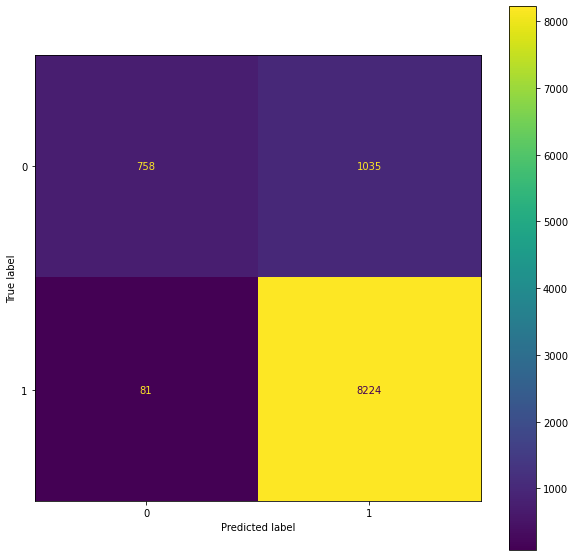

In [37]:
# построение матрицы ошибок
cm = confusion_matrix(target_test, sgd_preds, labels=sgd.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sgd.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

Из матрицы ошибок видим, что примеров, в которых водитель не виновен, гораздо меньше, чем тех, в которых он виновен в происшетсвии. На таких примерах (водтель не виновен) модель очень часто ошибается, предсказывая 1 вместо 0. Нужно собрать больше данных с невиновными водителями, чтобы модель научилась хорошо предсказывать такие примеры.

Далее проанализируем важность признаков.

Создадим датасет, состоящий из признака и его важности. Важностью здесь является коэффициент, на который умножается признак при голосовании (внутри модели) за проставление того или иного класса объекту. Чем выше по модулю коэффициент, тем больший вклад вносит этот признак.

In [92]:
# создание датасета важности признаков
coef_table = pd.DataFrame(list(df_features_train.columns)).copy()
coef_table.columns = ['feature']
coef_table.insert(len(coef_table.columns),"coef_value", sgd.coef_.transpose())
coef_table

,feature,coef_value
0,vehicle_age,0.048989
1,collision_date_20120101T000000000000000,0.037403
2,collision_date_20120102T000000000000000,0.071518
3,collision_date_20120103T000000000000000,-0.078564
4,collision_date_20120104T000000000000000,-0.023404
...,...,...
931,vehicle_age_140,0.092954
932,vehicle_age_150,0.057197
933,vehicle_age_160,0.011460
934,vehicle_transmission_auto,-0.061760


Теперь выведем на графике 20 самых важных признаков.

Text(0.5, 0, 'Feature Name')

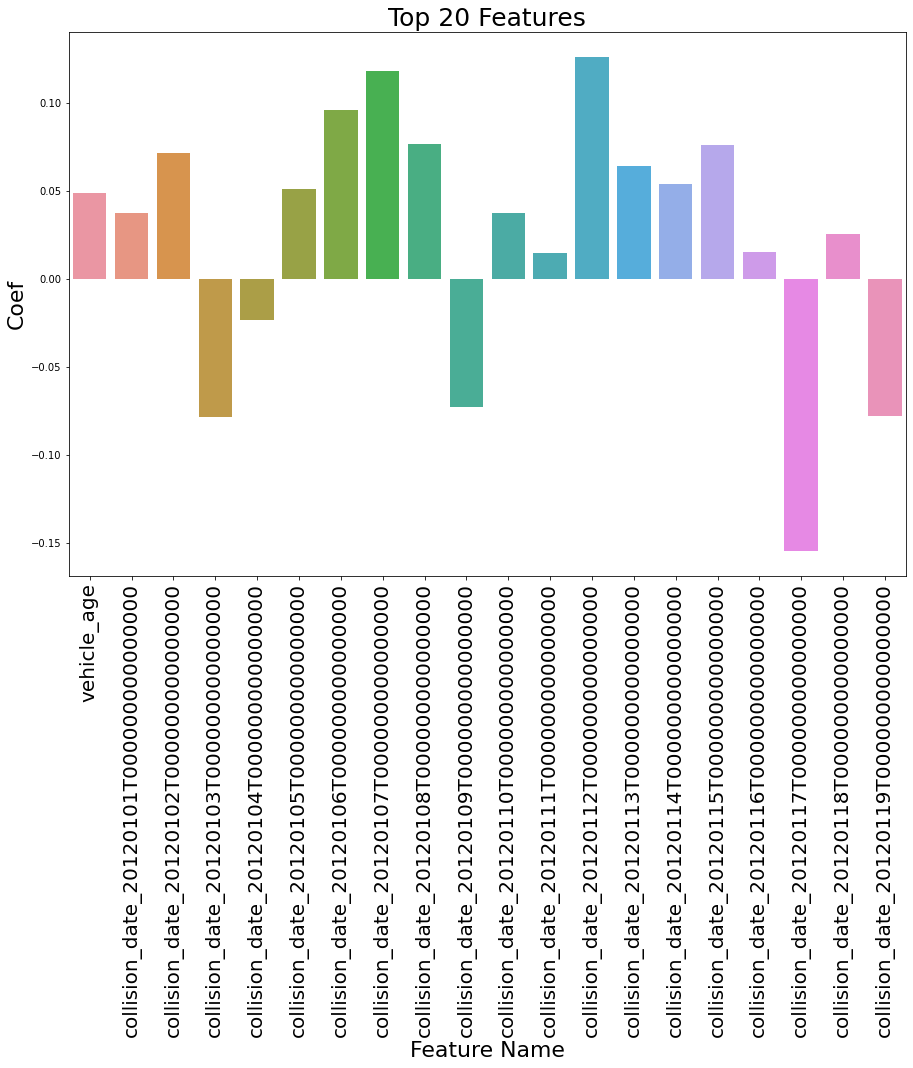

In [93]:
# построение графика важности признакова
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.barplot(x="feature",
            y="coef_value",
            data=coef_table.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

Самым важным фактором стала определённое время происшествия, т.е. мы можем сказать, что время происшествия в целом является самым важным фактором. Построим график зависимости времени происшествия от количества происшествий. Будем строить диаграмму частот: месяц - количество происшествий. 

In [31]:
# запрос для построения зависимости время происшествия-количество происшествий
query_accident_time = '''
SELECT EXTRACT('MONTH' FROM collision_date) AS month,
        COUNT(case_id) as accident_count
FROM collisions
WHERE EXTRACT('YEAR' FROM collision_date) = 2012
GROUP BY month;
''' 
# создание таблицы для анализа
accident_time_df = pd.read_sql_query(query_accident_time, con = engine)

In [33]:
# просмотр таблицы
accident_time_df

,month,accident_count
0,1.0,32020
1,2.0,30377
2,3.0,32498
3,4.0,29143
4,5.0,25168
5,6.0,3062
6,7.0,390
7,8.0,622
8,9.0,510
9,10.0,304


Text(0, 0.5, 'accident_count')

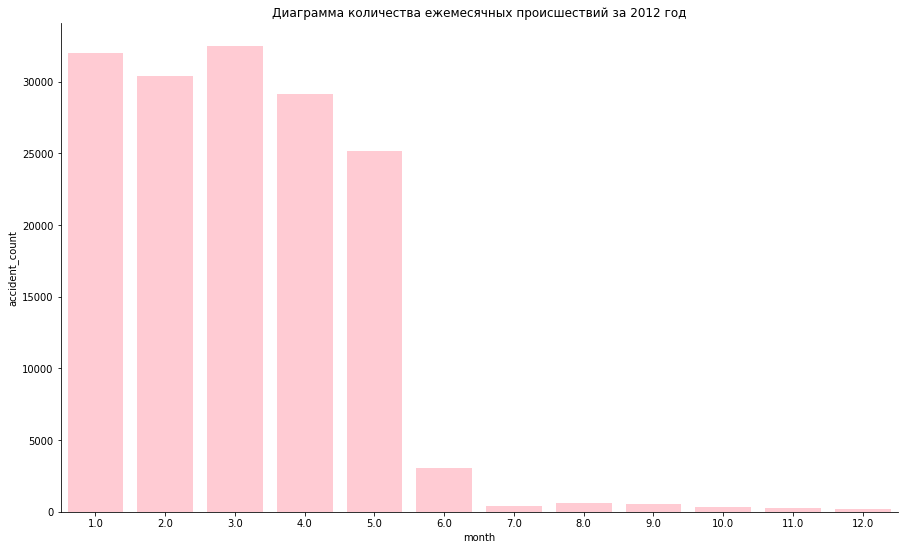

In [37]:
# диаграмма количества ежемесячных происшествий для 2012 года
f, ax = plt.subplots(figsize=(15, 9))
sns.despine(f)
g = sns.barplot(data=accident_time_df, x='month', y='accident_count',
                 palette='magma',
                 linewidth='.5',
                 facecolor='lightpink',
                 color='green', alpha=0.7)

g.set_title('Диаграмма количества ежемесячных происшествий за 2012 год')
g.set_xlabel('month')
g.set_ylabel('accident_count')

С января по май количество происшествий держится на высоком уровне, возможно это связано и с количеством машин на дороге, и с погодными условиями во время зимы и перехода из зимы в весну.

Если водитель садится в машину в один из названных выше месяцев, то в машине или на экране телефона в приложении бронирования автомобилей можно выводить сообщене о том, что текущий месяц является одним из самых опасных для вождения. Также дополнительно можно увеличивать коээфициент опасности трассы в некоторое количество раз при оценке маршрута.

**Вывод:**

Отобран самый важный фактор при обучении модели. Построена диаграмма звисимости самого важного фактора от количества ДТП на дороге.

## Выводы

Лучшая для данной задачи модель — **SGDClassifier()**. Такая обученная модель быстро отрабатывает на проде и точность предсказания данной модели достигает *94%*.

Создание адекватной системы оценки риска при выдаче авто возможно, однако предсказание виновности участника ДТП несовсем подходит для такой задачи. На мой взгляд необходимо взять данные происшествий, отобрать факторы, которые говорят о сложности трассы, разметить эти данные по категориям (количество категорий установить самостоятельно). Одну модель обучить предсказывать сложность трассы. Далее будет включаться вторая модель: я также предлагаю разметить данные в зависимости от состояния трассы в данный момент (погодные условия,время суток и т.д.) и состояния человека, т.е. это те данные, которые будут меняться из раза в раз. На основе двух предсказаний выводить коэффициент, который будет говорить о риске при выдаче автомобиля.

В качестве дополнтельных факторов можно взять стаж водителя и его количество аварий в год.